# Task 1: Preprocess and Explore the Data

## Objective
Load, clean, and understand the data to prepare it for modeling.

## Instructions
1. Extract Historical Financial Data
2. Data Cleaning and Understanding
3. Conduct Exploratory Data Analysis (EDA)
4. Seasonality and Trend Analysis
5. Calculate Risk Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_loader import fetch_data, clean_data

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Extract and Clean Data

In [2]:
assets = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

# Fetch data
raw_data = fetch_data(assets, start_date, end_date)
data = clean_data(raw_data)

# Display head
data.head()

2026-01-25 18:29:34,667 - INFO - Fetching data for ['TSLA', 'BND', 'SPY'] from 2015-01-01 to 2026-01-15...
[*********************100%***********************]  3 of 3 completed
2026-01-25 18:29:39,361 - INFO - Data fetched successfully.
2026-01-25 18:29:39,362 - INFO - Cleaning data...
2026-01-25 18:29:39,365 - INFO - Data cleaning complete.


Ticker            BND                                                     SPY  \
Price            Open       High        Low      Close     Volume        Open   
Date                                                                            
2015-01-02  60.225256  60.415220  60.217948  60.385994  2218800.0  171.378569   
2015-01-05  60.451715  60.583228  60.422490  60.561310  5820100.0  169.543319   
2015-01-06  60.663618  60.919335  60.663618  60.736679  3887600.0  167.816050   
2015-01-07  60.743953  60.846239  60.678199  60.773178  2433400.0  167.259706   
2015-01-08  60.722039  60.722039  60.619752  60.678204  1873400.0  169.410413   

Ticker                                                            TSLA  \
Price             High         Low       Close       Volume       Open   
Date                                                                     
2015-01-02  171.793770  169.551672  170.589676  121465900.0  14.858000   
2015-01-05  169.709397  167.201590  167.508835  169632600.0  14.303333   
2015-01-06  168.339208  165.133853  165.931046  209151400.0  14.004000   
2015-01-07  168.339232  166.811294  167.998764  125346700.0  14.223333   
2015-01-08  171.195786  169.393814  170.979874  147217800.0  14.187333   

Ticker                                                   
Price            High        Low      Close      Volume  
Date                                                     
2015-01-02  14.883333  14.217333  14.620667  71466000.0  
2015-01-05  14.433333  13.810667  14.006000  80527500.0  
2015-01-06  14.280000  13.614000  14.085333  93928500.0  
2015-01-07  14.318667  13.985333  14.063333  44526000.0  
2015-01-08  14.253333  14.000667  14.041333  51637500.0

## 2. Exploratory Data Analysis (EDA)

### Closing Price Over Time

MultiIndex([( 'BND',   'Open'),
            ( 'BND',   'High'),
            ( 'BND',    'Low'),
            ( 'BND',  'Close'),
            ( 'BND', 'Volume'),
            ( 'SPY',   'Open'),
            ( 'SPY',   'High'),
            ( 'SPY',    'Low'),
            ( 'SPY',  'Close'),
            ( 'SPY', 'Volume'),
            ('TSLA',   'Open'),
            ('TSLA',   'High'),
            ('TSLA',    'Low'),
            ('TSLA',  'Close'),
            ('TSLA', 'Volume')],
           names=['Ticker', 'Price'])


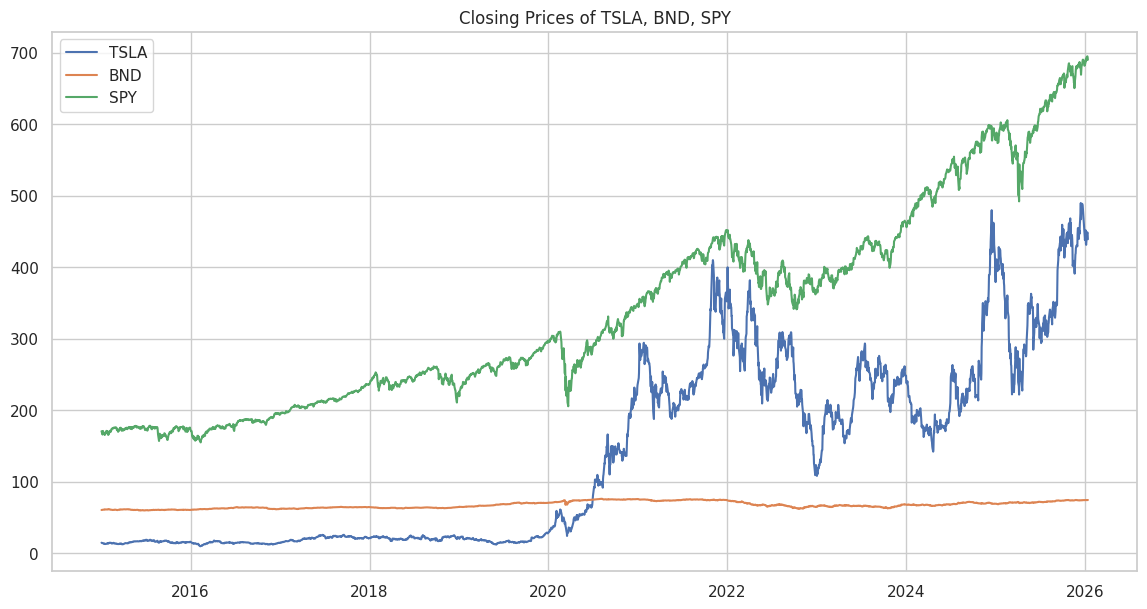

In [3]:
# We need to handle the MultiIndex columns if present.
# yfinance with group_by='ticker' returns (Ticker, OHLCV)
# Let's inspect the columns
print(data.columns)

# Plot Closing Prices
plt.figure(figsize=(14, 7))
for ticker in assets:
    if isinstance(data.columns, pd.MultiIndex):
        plt.plot(data.index, data[ticker]['Close'], label=ticker)
    else:
        # Fallback if structure is flat (likely not with group_by='ticker')
        pass

plt.title('Closing Prices of TSLA, BND, SPY')
plt.legend()
plt.show()

### Daily Percentage Change (Volatility)

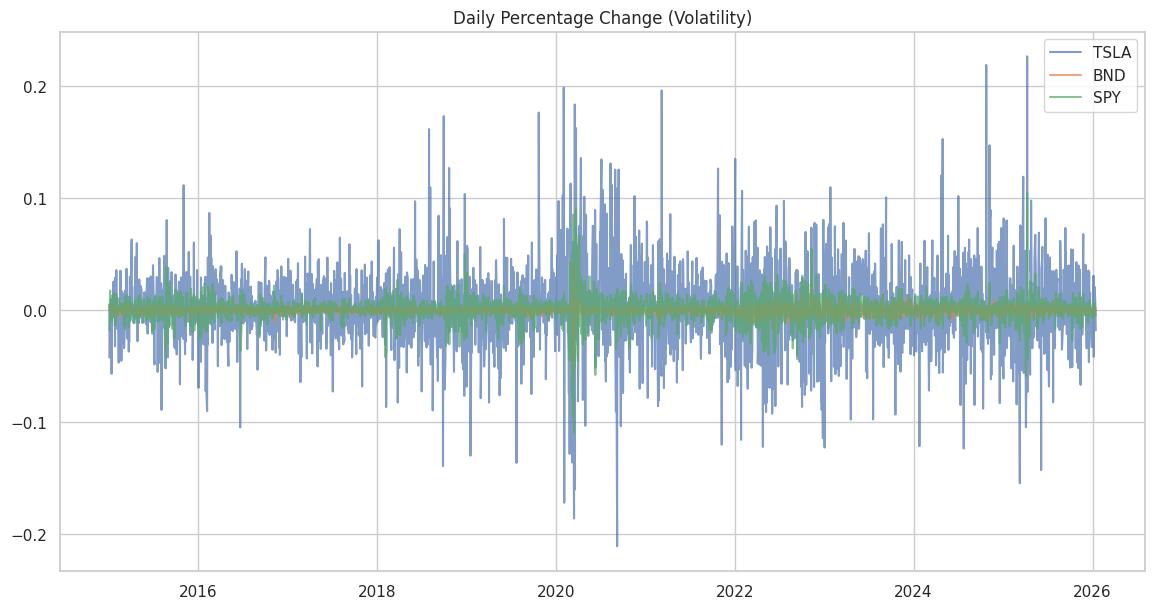

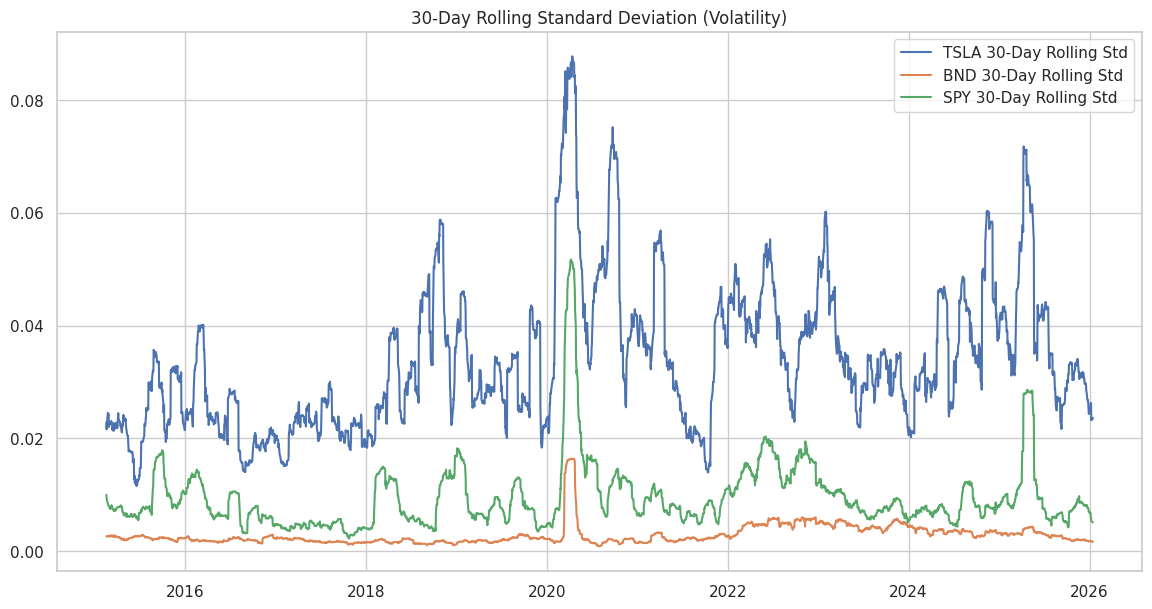

In [4]:
# Calculate Daily Returns
daily_returns = pd.DataFrame()

if isinstance(data.columns, pd.MultiIndex):
    for ticker in assets:
        daily_returns[ticker] = data[ticker]['Close'].pct_change()
else:
    # Handle flat structure
    pass

daily_returns.dropna(inplace=True)

# Plot Daily Returns
plt.figure(figsize=(14, 7))
for ticker in assets:
    plt.plot(daily_returns.index, daily_returns[ticker], label=ticker, alpha=0.7)

plt.title('Daily Percentage Change (Volatility)')
plt.legend()
plt.show()

# Rolling Methods
window = 30
rolling_std = daily_returns.rolling(window=window).std()

plt.figure(figsize=(14, 7))
for ticker in assets:
    plt.plot(rolling_std.index, rolling_std[ticker], label=f'{ticker} {window}-Day Rolling Std')
plt.title(f'{window}-Day Rolling Standard Deviation (Volatility)')
plt.legend()
plt.show()

### Outlier Detection

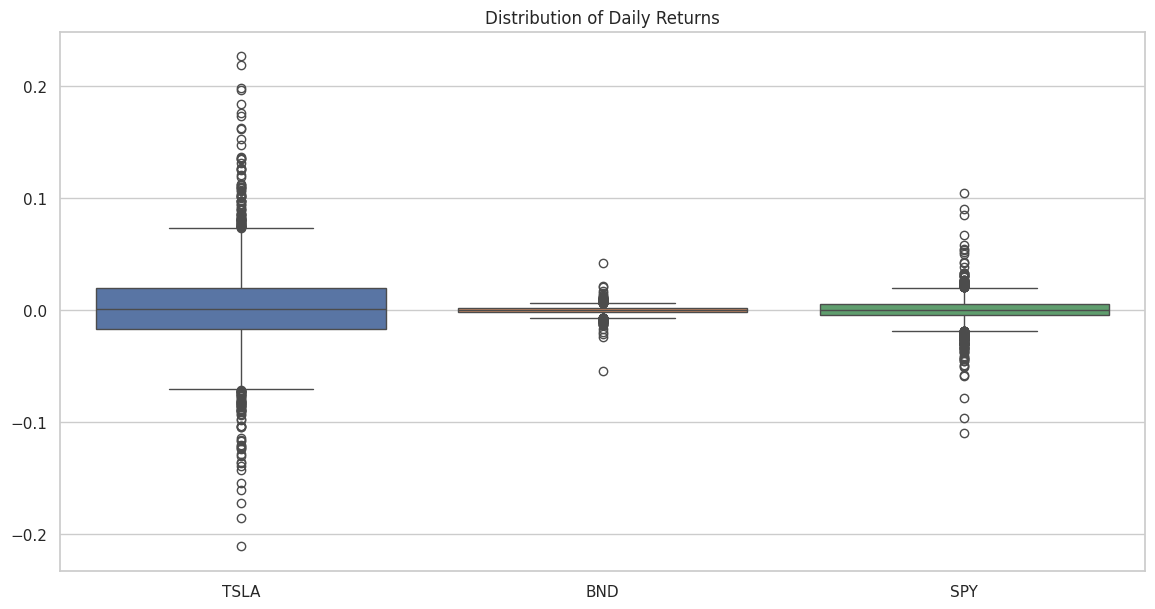

TSLA has 44 outliers beyond 3 std dev.
BND has 32 outliers beyond 3 std dev.
SPY has 39 outliers beyond 3 std dev.


In [5]:
# Visualize distribution of returns
plt.figure(figsize=(14, 7))
sns.boxplot(data=daily_returns)
plt.title('Distribution of Daily Returns')
plt.show()

# Identify outliers (e.g., beyond 3 sigma)
outliers = {}
for ticker in assets:
    mean = daily_returns[ticker].mean()
    std = daily_returns[ticker].std()
    threshold = 3 * std
    outlier_dates = daily_returns[(daily_returns[ticker] > mean + threshold) | (daily_returns[ticker] < mean - threshold)].index
    outliers[ticker] = len(outlier_dates)
    print(f"{ticker} has {len(outlier_dates)} outliers beyond 3 std dev.")

### Correlation Analysis
Analyze the correlation between the daily returns of different assets to understand their relationships using a heatmap.

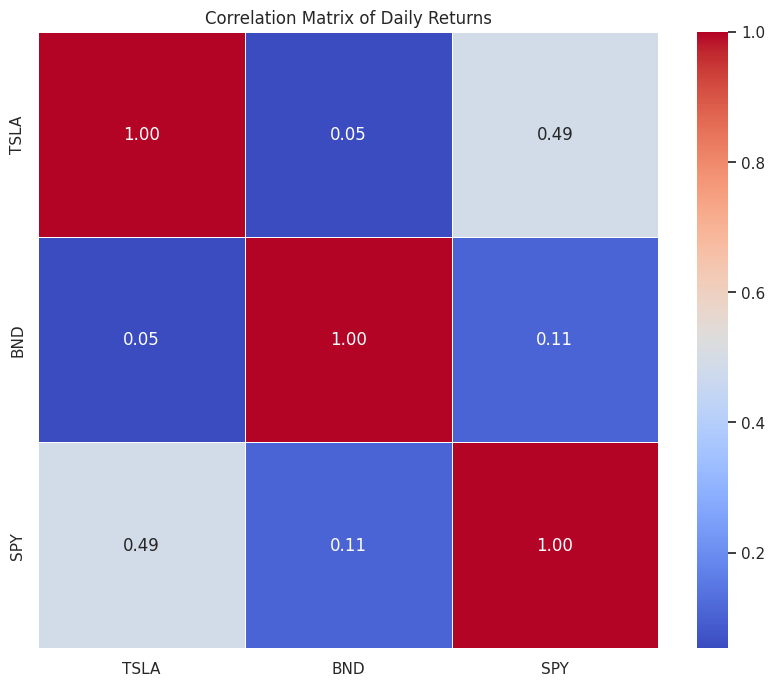

In [8]:
# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

## 3. Stationarity and Trend Analysis (ADF Test)
Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity in the time series data. Stationarity is a key assumption for many time series forecasting models.

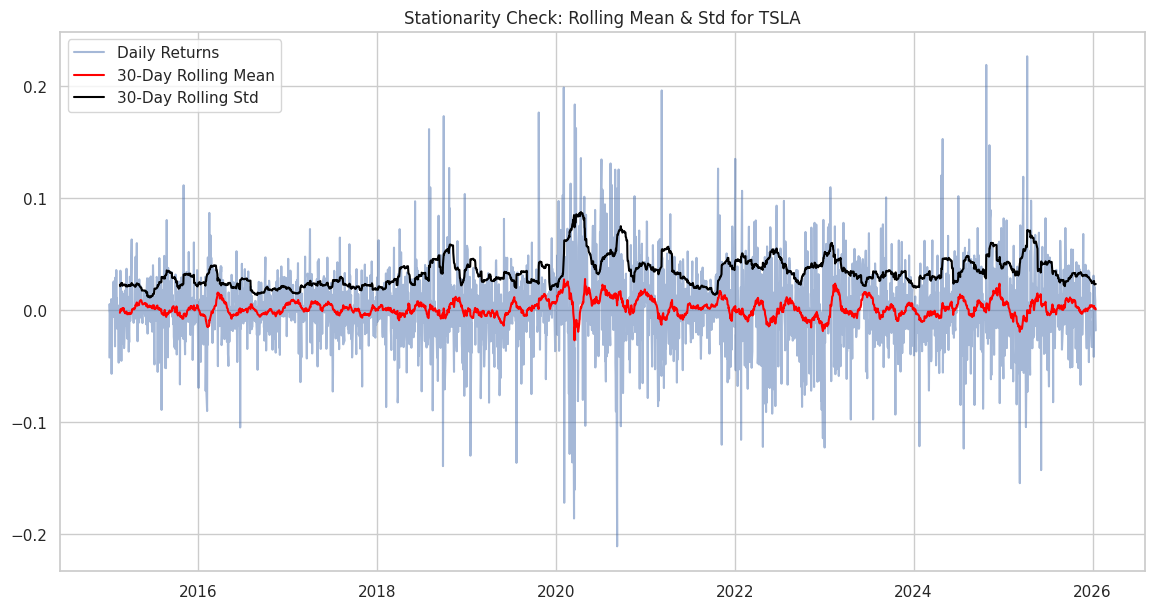

In [9]:
# Visual inspection of stationarity: Rolling Mean and Standard Deviation
# We'll stick to Daily Returns as prices are usually non-stationary
window = 30
rolling_mean = daily_returns.rolling(window=window).mean()
rolling_std = daily_returns.rolling(window=window).std()

plt.figure(figsize=(14, 7))
# Plot Returns for one asset (e.g., TSLA) to avoid clutter, or all if feasible. 
# Let's plot for the first asset in the list as an example.
asset_to_plot = assets[0] 

plt.plot(daily_returns.index, daily_returns[asset_to_plot], label='Daily Returns', alpha=0.5)
plt.plot(rolling_mean.index, rolling_mean[asset_to_plot], label=f'{window}-Day Rolling Mean', color='red')
plt.plot(rolling_std.index, rolling_std[asset_to_plot], label=f'{window}-Day Rolling Std', color='black')

plt.title(f'Stationarity Check: Rolling Mean & Std for {asset_to_plot}')
plt.legend()
plt.show()

In [6]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Result: Stationary (Reject Null Hypothesis)")
    else:
        print("Result: Non-Stationary (Fail to Reject Null Hypothesis)")
    print('-' * 30)

# Check stationarity for Closing Prices and Daily Returns
for ticker in assets:
    # Close Price
    if isinstance(data.columns, pd.MultiIndex):
        series = data[ticker]['Close']
    else:
        series = data[ticker] # Fallback
        
    print(f"--- {ticker} Closing Price ---")
    adf_test(series, f"{ticker} Close")
    
    # Returns
    print(f"--- {ticker} Daily Returns ---")
    adf_test(daily_returns[ticker], f"{ticker} Returns")
    print("\n")

--- TSLA Closing Price ---
ADF Test for TSLA Close:
ADF Statistic: -0.7801569882105672
p-value: 0.8248814297221101
Result: Non-Stationary (Fail to Reject Null Hypothesis)
------------------------------
--- TSLA Daily Returns ---
ADF Test for TSLA Returns:
ADF Statistic: -53.019618544243606
p-value: 0.0
Result: Stationary (Reject Null Hypothesis)
------------------------------


--- BND Closing Price ---
ADF Test for BND Close:
ADF Statistic: -1.0513784518233378
p-value: 0.7340673155296384
Result: Non-Stationary (Fail to Reject Null Hypothesis)
------------------------------
--- BND Daily Returns ---
ADF Test for BND Returns:
ADF Statistic: -10.433740959431798
p-value: 1.5860376886255805e-18
Result: Stationary (Reject Null Hypothesis)
------------------------------


--- SPY Closing Price ---
ADF Test for SPY Close:
ADF Statistic: 1.1708805479328768
p-value: 0.9957783892230937
Result: Non-Stationary (Fail to Reject Null Hypothesis)
------------------------------
--- SPY Daily Returns --

## 4. Calculate Risk Metrics
- Value at Risk (VaR)
- Sharpe Ratio

In [7]:
# Value at Risk (VaR) at 95% confidence level
confidence_level = 0.05
var_95 = daily_returns.quantile(confidence_level)
print("Value at Risk (95% Confidence):")
print(var_95)

# Sharpe Ratio
# Assuming risk-free rate is close to 0 for daily, or usage of 0.04/252
rf = 0.04 / 252 # Annual risk free rate 4%
sharpe_ratios = (daily_returns.mean() - rf) / daily_returns.std()
# Annualized Sharpe Ratio
sharpe_annual = sharpe_ratios * np.sqrt(252)

print("\nAnnualized Sharpe Ratios:")
print(sharpe_annual)

Value at Risk (95% Confidence):
TSLA   -0.052529
BND    -0.004796
SPY    -0.016719
Name: 0.05, dtype: float64

Annualized Sharpe Ratios:
TSLA    0.753852
BND    -0.365265
SPY     0.578863
dtype: float64
